In [5]:
import numpy as np
import matplotlib.pyplot as plt

import aero_model
import dynamic
# Modèle d'avion
aircraft = aero_model.Airbus_A319_100()

In [3]:
aircraft.set_options(stall=True, buffeting=False, wave_drag=False)

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def optimize_for_range_existing_trim_mass_cg(aero_m, altp, mass, cg_pct_mac):
    """
    Optimisation de Fn/V en utilisant graceful_trim avec masse et centrage variables
    """
    # Mise à jour des paramètres masse et centrage
    aero_m.m = mass
    rxg = cg_pct_mac / 100.0  # conversion %MAC -> fraction MAC
    aero_m.set_balance(rxg)

    speeds = np.linspace(130, 250, 50)  # plage de vitesses adaptée à l'A319
    fn_over_v = []
    solutions = []

    previous_guess = [0.05, 0.0, 0.5]  # [aoa, dtrim, dthr]

    for tas in speeds:
        aoa, dtrim, dthr = dynamic.graceful_trim(aero_m, altp, tas)

        if not np.isnan(aoa):
            previous_guess = [aoa, dtrim, dthr]

            res = dynamic.get_trim_level_flight(aero_m, altp, tas, use_saturations=False)

            fu = res["fu"][0]  # daN
            fn = fu * 10       # N

            fn_over_v.append(fn / tas)
            solutions.append(res)

        else:
            fn_over_v.append(np.nan)
            solutions.append(None)

    fn_over_v = np.array(fn_over_v)

    if np.all(np.isnan(fn_over_v)):
        raise Exception("Aucune convergence obtenue sur la plage de vitesses testée.")
        
    idx_opt = np.nanargmin(fn_over_v)
    sol_opt = solutions[idx_opt]

    # Affichage
    plt.figure(figsize=(10, 6))
    plt.plot(speeds, fn_over_v, label=r"$F_n/V$")
    plt.scatter(speeds[idx_opt], fn_over_v[idx_opt], color='red', label="Optimal")
    plt.xlabel("Vitesse vraie TAS (m/s)")
    plt.ylabel(r"$F_n/V$ (N·s/m)")
    plt.title(f"Optimisation (m={mass/1000:.1f} t, CG={cg_pct_mac:.1f} %MAC)")
    plt.grid()
    plt.legend()
    plt.show()

    return sol_opt


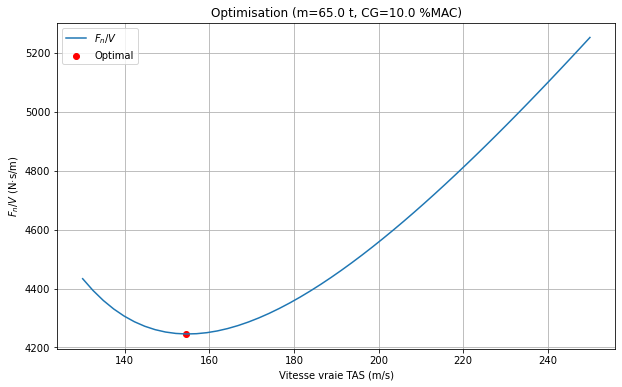

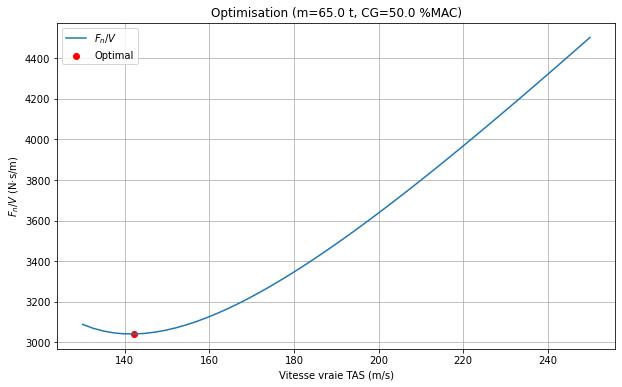

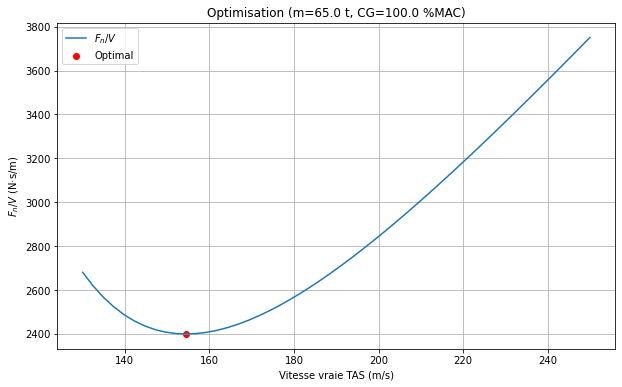

In [ ]:
aircraft = aero_model.Airbus_A319_100()
altp = 5000      # altitude en m
mass = 65000     # masse en kg
cg = 27.5        # centrage en %MAC

sol_opt = optimize_for_range_existing_trim_mass_cg(aircraft, altp, mass, cg)
